# Geopandas categories in legends

# Introduction
I recently ran across a little wrinkle in plotting maps with Geopandas.  In this particular case I was plotting a subset of a large DataFrame, and the Legends produced were misleading.  This brief blog post show a workaround.

---------------------------------
# Implementation
## Define environment

### Import of packages used

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

### Notebook utilities used

In [2]:
%load_ext watermark

In [3]:
%load_ext lab_black

## Get example dataset
We will use a sample built-in dataset that Geopandas provides to illustrate the glitch: first, plot and print the contents.

In [4]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

<AxesSubplot:>

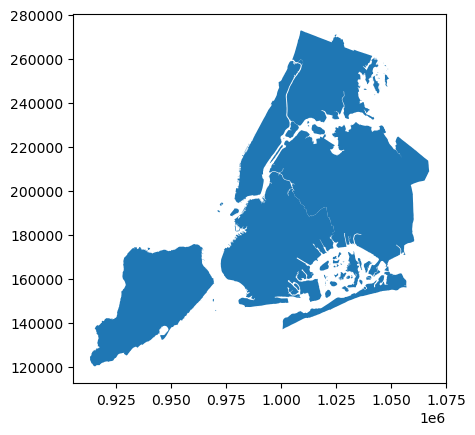

In [5]:
df = gpd.read_file(gpd.datasets.get_path("nybb"))
df.plot()

In [6]:
df.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


### Set Borough Name column as a categorical column
We would typically do this on a large DataFrame in order to improve efficiency

In [7]:
df['BoroName'] = df['BoroName'].astype('category')

List out the categories.

In [8]:
df['BoroName'].cat.categories

Index(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], dtype='object')

Now request a plot, where the Boroughs are distinguished by color

<AxesSubplot:>

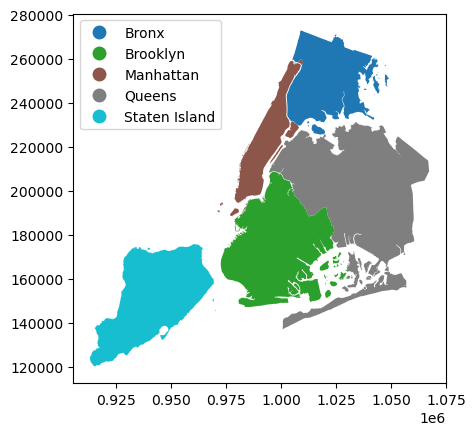

In [9]:
df.plot(
    column='BoroName',
    legend=True,
    legend_kwds={'loc': 'upper left',},
)

Now we will plot just a subset of the data.  We subset by Borough Code.  First, we list all codes.

In [10]:
[code for code in df['BoroCode']]

[5, 4, 3, 1, 2]

Now we mask out all those Boroughs that have a code number value not in 3, 4, or 5.

<AxesSubplot:>

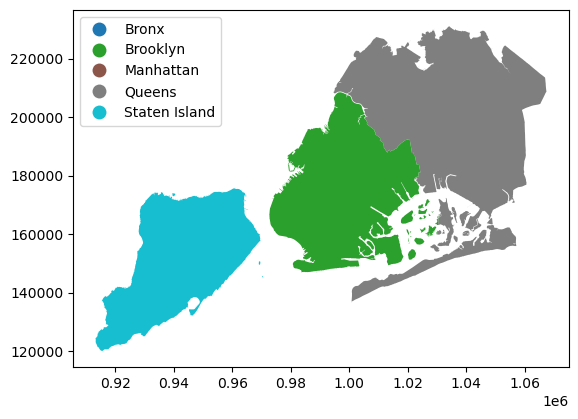

In [11]:
selected_codes = [3, 4, 5]
df2 = df[
    [code in selected_codes for code in df['BoroCode']]
].copy()
df2.plot(
    column='BoroName',
    legend=True,
    legend_kwds={'loc': 'upper left',},
)

Now you can see the problem:  **although we only plotted 3 Boroughs, the Legend shows five colors!**

We can see that the categories have been unchanged by our subsetting operation.

In [12]:
df2['BoroName'].cat.categories

Index(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], dtype='object')

------------------------
## Solution

We define a helper function that strips out unused categories 

In [13]:
def strip_unused_categories(
    df: pd.DataFrame, column_name: str
):
    '''
    strip_unused_categories:  remove unused categories from a categorical colm definition
    
    Parameters:
    df: pandas DataFrame, with one column being  categorical
    
    column_name: str - name of categorical column to be pruned
    
    Returns:
    None
    
    Side Effects:
    Categories of referenced columns might be changed
    
    Example:
    If we have: 
        0     Blue
        1    Green
        2     Blue
        3    Green
        4    Brown
        Name: color, dtype: category
        Categories (4, object): [Blue, Brown, Green, Red]
    
    we want:
        0     Blue
        1    Green
        2     Blue
        3    Green
        4    Brown
        Name: color, dtype: category
        Categories (3, object): [Blue, Green, Brown]
        
        Usage Example:
        df = pd.DataFrame(
            {
                'color': np.random.choice(
                    ['Blue', 'Green', 'Brown', 'Red'], 50
                )
            }
        )

        df.color = df.color.astype('category')
        print(df.color.cat.categories)

        df = df.query('color != "Brown"')
        strip_unused_categories(df, 'color')
        print(df.color.cat.categories)
        
        ->
        Index(['Blue', 'Brown', 'Green', 'Red'], dtype='object')
        Index(['Blue', 'Green', 'Red'], dtype='object')
        
    '''

    # get the all the current category names as a list
    current = list(df[column_name].cat.categories)

    # get list on unique categories actually used
    used = df[column_name].unique()

    for cat_name in current:
        if cat_name not in used:
            df[column_name] = df[
                column_name
            ].cat.remove_categories(cat_name)
        # end if
    # end for


# end strip_unused_categories

Using the helper function, we prune the category list

In [14]:
strip_unused_categories(df2, 'BoroName')

Now the plot has a legend that makes sense!

<AxesSubplot:>

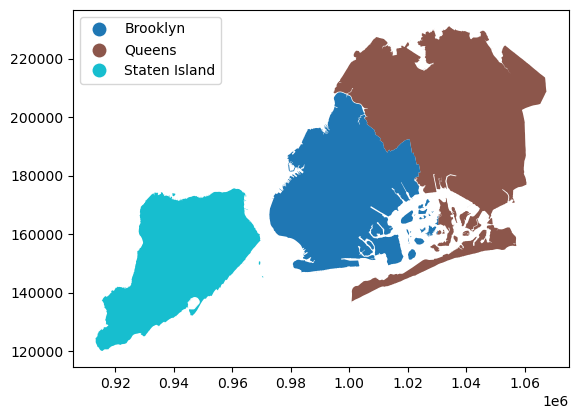

In [15]:
df2.plot(
    column='BoroName',
    legend=True,
    legend_kwds={'loc': 'upper left',},
)

Just checking our prune operation worked as expected.

In [16]:
df2['BoroName'].cat.categories

Index(['Brooklyn', 'Queens', 'Staten Island'], dtype='object')

Just as a side note, the misleading Legend also appears if other means of subsetting are used.

<AxesSubplot:>

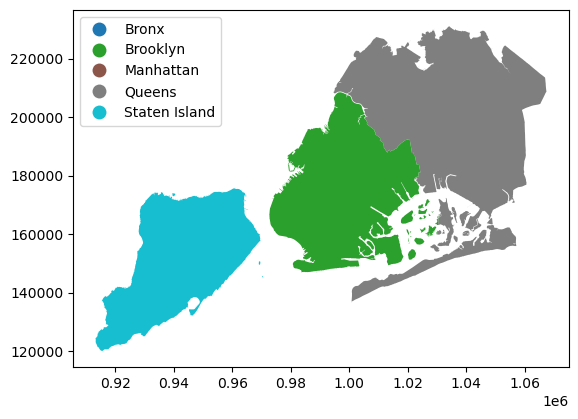

In [17]:
df.query('BoroCode>2').plot(
    column='BoroName',
    legend=True,
    legend_kwds={'loc': 'upper left',},
)

---------------------------
## Reproducability

In [18]:
%watermark -iv

pandas   : 1.5.2
numpy    : 1.23.5
geopandas: 0.9.0



In [19]:
%watermark

Last updated: 2024-02-04T19:12:33.113777+10:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [20]:
%watermark -co

conda environment: mapping2

